In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

In [2]:
#Importing dataset

weather = pd.read_csv("Turin_Weather_Data.csv", index_col="DATE")

In [3]:
#Core parameters based on dataset documentation

core_weather = weather[["PRCP", "SNWD", "TAVG" ,"TMAX", "TMIN"]].copy()

In [4]:
#Renaming columns and dropping years 1973 and 1974

core_weather.columns = ["precip", "snow_depth", "avg_temp", "temp_max", "temp_min"]

core_weather.index = pd.to_datetime(core_weather.index)
core_weather = core_weather[core_weather.index.year != 1973]
core_weather = core_weather[core_weather.index.year != 1974]

In [5]:
#Filling in missing values

#Filling missing values for "precip" and "snow_depth" with zero
core_weather["precip"] = core_weather["precip"].fillna(0)
core_weather["snow_depth"] = core_weather["snow_depth"].fillna(0)

#Filling missing "temp_min" "temp_max" values
core_weather.loc[(core_weather["temp_max"].apply(pd.isnull) == True) & (core_weather["temp_min"].apply(pd.isnull) == False), "temp_max"] = 2*core_weather["avg_temp"]-core_weather["temp_min"]
core_weather.loc[(core_weather["temp_max"].apply(pd.isnull) == False) & (core_weather["temp_min"].apply(pd.isnull) == True), "temp_min"] = 2*core_weather["avg_temp"]-core_weather["temp_max"]
core_weather.loc[(core_weather["temp_max"].apply(pd.isnull) == True) & (core_weather["temp_min"].apply(pd.isnull) == True), ["temp_max", "temp_min"]] = core_weather["avg_temp"]

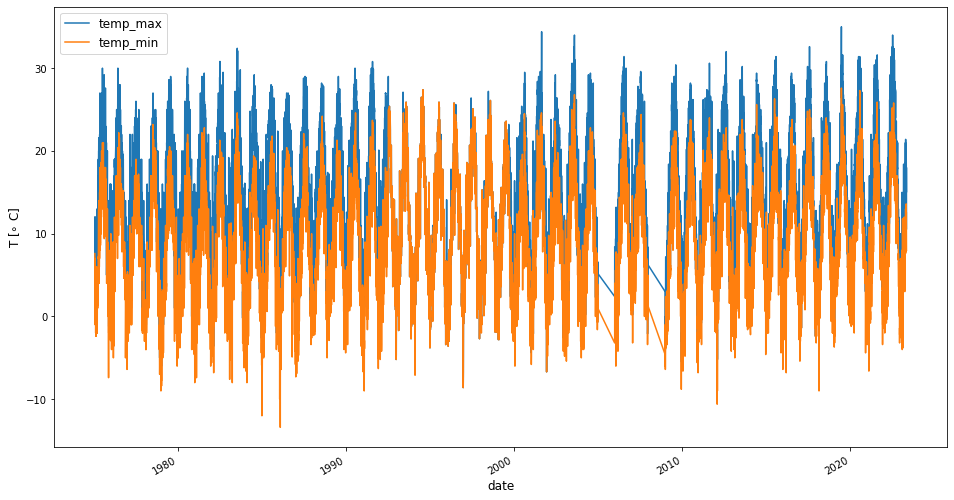

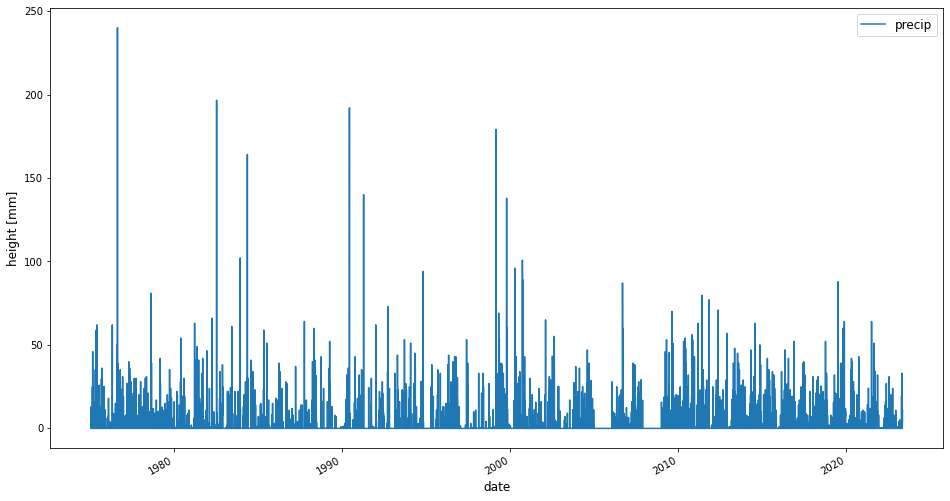

In [7]:
#Various plots

TMTm = core_weather[["temp_max", "temp_min"]].plot(figsize = (16,9))
plt.savefig("TMTm.png", facecolor = "w")
TMTm.set_xlabel("date", fontsize = 12)
TMTm.set_ylabel("T [$\circ$ C]", fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

precip = core_weather["precip"].plot(figsize = (16,9))
precip.set_xlabel("date", fontsize = 12)
precip.set_ylabel("height [mm]", fontsize = 12)
plt.legend(fontsize = 12)
plt.savefig("precip.png", facecolor = "w")
plt.show()

In [8]:
#Creating the target column, indicating next day's avg_temp

core_weather["target"] = core_weather.shift(-1)["avg_temp"]
core_weather = core_weather.iloc[:-1,:].copy()

In [9]:
#Predictor function

def create_predictions(predictors, core_weather, reg):
    train = core_weather.loc[:"2020-12-31"]
    test = core_weather.loc["2021-01-01":]
    reg.fit(train[predictors], train["target"])
    predictions = reg.predict(test[predictors])
    error = mean_absolute_error(test["target"], predictions)
    combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ["actual", "predictions"]
    return error, combined

In [10]:
#Function parameters

reg = Ridge(alpha=.1)
predictors = ["precip", "snow_depth", "avg_temp", "temp_max", "temp_min"]

The mean absolute error is: 1.4429857723281119

The regression coefficients are: [2.99261781e-02 2.53061620e-04 8.83604272e-01 2.89321596e-02
 4.77762807e-02]

Plotting the prediction against the actual values: 


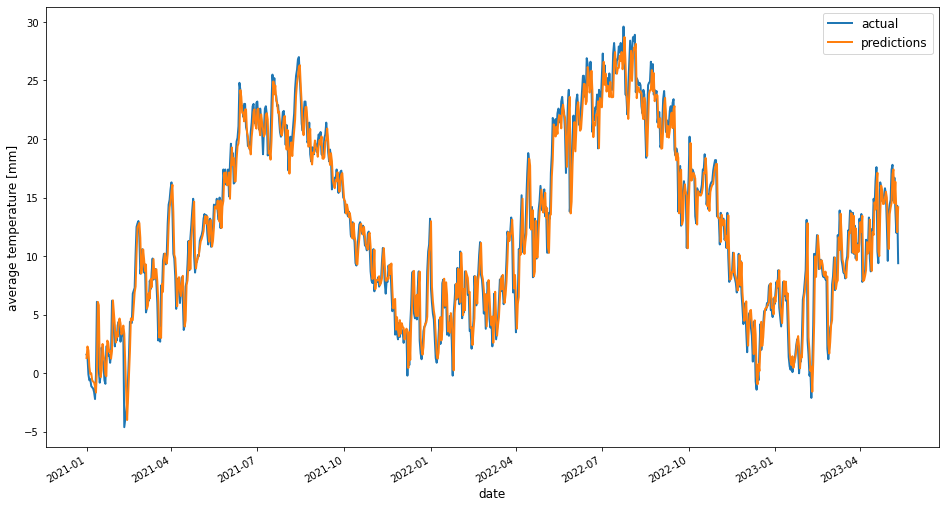

In [11]:
# Prediction results

error, combined = create_predictions(predictors, core_weather, reg)

print("The mean absolute error is: " + str(error))
print()
print("The regression coefficients are: " + str(reg.coef_))
print()
print("Plotting the prediction against the actual values: ")

avg_temp_plot = combined.plot(lw=2, figsize=(16,9))
avg_temp_plot.set_ylabel("average temperature [mm]", size = 12)
avg_temp_plot.set_xlabel("date", size = 12)
plt.legend(fontsize = 12)
plt.savefig("actual_vs_predictions_plot.png", facecolor = "w")
plt.show()